## Step 0: Package Installation & Setup

### 0.1.Package Installation

---



This code cell installs all the necessary packages for the project, including NetworkX integration with ArangoDB, NVIDIA cuGraph for GPU acceleration, LangChain for AI reasoning, and Groq for large language model access.

In [1]:
# Install nx-arangodb
!pip install nx-arangodb

# Install nx-cugraph (if GPU available)
!pip install cugraph-cu12 --extra-index-url https://pypi.nvidia.com


# Install LangChain & LangGraph
!pip install --upgrade langchain langchain-community langchain-openai langgraph langchain-together

# Install Together AI and Gradio
!pip install langchain_groq


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.6/114.6 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.4.2
    Uninstalling networkx-3.4.2:
      Successfully uninstalled networkx-3.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which

### 0.2.GPU Verification
----
This cell verifies the availability of an NVIDIA GPU and displays information about the CUDA compiler version, ensuring GPU acceleration can be utilized for graph analytics.

In [2]:
!nvidia-smi
!nvcc --version

Mon Mar 10 06:37:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### 0.3.Module Imports & Configuration
----
This comprehensive cell imports all required packages, configures the ArangoDB Cloud connection, verifies database connectivity, and sets up the Together AI client for language model access.

In [3]:
from arango import ArangoClient
from langchain_community.graphs import ArangoGraph
from langchain.chains import ArangoGraphQAChain
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from groq import Groq
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import re
import json
import os
import textwrap

# Set GROQ API key
os.environ["GROQ_API_KEY"] = "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"

# Initialize ArangoDB client
client = ArangoClient(hosts='https://095fcc8bc2f7.arangodb.cloud:8529')
db = client.db('_system', username='root', password='Z9Vsj8O46ZrTDW5sfbvS')

# Instantiate LangChain-compatible ArangoDB graph
arango_graph = ArangoGraph(db)

# Initialize Groq client
groq_client = Groq(api_key=os.environ.get("GROQ_API_KEY"))


## Step 1: Choose & Prepare Dataset for NetworkX And Putting That Data Into NetworkX.

### 1.1.Load Dataset


In [4]:
# --------------------------
# Step 1: Load JSON Data
# --------------------------
# Adjust file paths if needed.
with open('diseases_35.json', 'r') as f:
    diseases = json.load(f)

with open('patients_550.json', 'r') as f:
    patients = json.load(f)

with open('edges_corrected_100.json', 'r') as f:
    edges = json.load(f)


###1.2.Create the Graph and Add Nodes by putting the Data Into NetworkX

In [5]:
# --------------------------
# Step 2: Create the Graph and Add Nodes
# --------------------------
G = nx.Graph()  # Use nx.DiGraph() if you need a directed graph

# Add disease nodes
for disease in diseases:
    node_id = disease['_key']
    G.add_node(node_id,
               node_type='disease',
               name=disease['name'],
               medication=disease['medication'])

# Add patient nodes
for patient in patients:
    node_id = patient['_key']
    G.add_node(node_id,
               node_type='patient',
               name=patient['name'],
               age=patient.get('age', None),
               gender=patient.get('gender', None),
               blood_type=patient.get('blood_type', None))


##1.3.Add Edges from the Edges JSON

In [6]:
# --------------------------
# Step 3: Add Edges from the Edges JSON
# --------------------------
# The _from and _to fields have format "collection/key". We extract the key.
for edge in edges:
    src = edge["_from"].split("/")[-1]
    dst = edge["_to"].split("/")[-1]
    G.add_edge(src, dst,
               relation=edge.get("relation", "related"),
               disease=edge.get("disease", None))

# Optional: Print some debug information
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("Sample nodes:", list(G.nodes(data=True))[:5])
print("Sample edges:", list(G.edges(data=True))[:5])

Number of nodes: 585
Number of edges: 100
Sample nodes: [('D1', {'node_type': 'disease', 'name': 'Diabetes', 'medication': 'Metformin'}), ('D2', {'node_type': 'disease', 'name': 'Hypertension', 'medication': 'Lisinopril'}), ('D3', {'node_type': 'disease', 'name': 'Asthma', 'medication': 'Albuterol'}), ('D4', {'node_type': 'disease', 'name': 'COVID-19', 'medication': 'Remdesivir'}), ('D5', {'node_type': 'disease', 'name': 'Heart Disease', 'medication': 'Atorvastatin'})]
Sample edges: [('D1', 'P19', {'relation': 'diagnosed_with', 'disease': None}), ('D1', 'P22', {'relation': 'diagnosed_with', 'disease': None}), ('D1', 'P36', {'relation': 'diagnosed_with', 'disease': None}), ('D2', 'P4', {'relation': 'diagnosed_with', 'disease': None}), ('D2', 'P7', {'relation': 'diagnosed_with', 'disease': None})]


##1.4.Compute Layout and Create Plotly Traces

In [7]:
# --------------------------
# Step 4: Compute Layout and Create Plotly Traces
# --------------------------
pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)

# Build edge traces
edge_x = []
edge_y = []
for source, target in G.edges():
    x0, y0 = pos[source]
    x1, y1 = pos[target]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])
edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines'
)

# Build node traces
node_x = []
node_y = []
node_text = []
node_color = []
for node, data in G.nodes(data=True):
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    # Combine node id and type in the hover text
    node_text.append(f"{node}<br>{data.get('node_type', '')}")
    if data.get("node_type") == "patient":
        node_color.append("lightblue")
    else:
        node_color.append("salmon")

node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers+text',
    hoverinfo='text',
    marker=dict(
        color=node_color,
        size=10,
        line_width=2
    ),
    text=[node for node in G.nodes()]
)


##1.5.Create and Display the Plotly Figure

In [8]:
# --------------------------
# Step 5: Create and Display the Plotly Figure
# --------------------------
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Interactive Patients-Diseases Graph',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                )
)

fig.show()


##1.6.Visualization of diseases data Using NetworkX

In [9]:
# Load diseases data
with open('diseases_35.json', 'r') as f:
    diseases = json.load(f)

# Create a graph for diseases (each disease is a node)
G_diseases = nx.Graph()
for disease in diseases:
    node_id = disease["_key"]
    G_diseases.add_node(node_id, label=disease["name"], medication=disease["medication"])

# Compute layout
pos_diseases = nx.spring_layout(G_diseases, seed=42)

# Build node traces
node_x = []
node_y = []
node_text = []
for node in G_diseases.nodes():
    x, y = pos_diseases[node]
    node_x.append(x)
    node_y.append(y)
    data = G_diseases.nodes[node]
    node_text.append(f"{data['label']}<br>Medication: {data['medication']}")

node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers+text',
    text=[G_diseases.nodes[node]['label'] for node in G_diseases.nodes()],
    hovertext=node_text,
    hoverinfo='text',
    marker=dict(
        color='salmon',
        size=20,
        line=dict(width=2)
    )
)

# Create and display the figure
fig_diseases = go.Figure(data=[node_trace],
                         layout=go.Layout(
                             title='Diseases Graph',
                             titlefont_size=16,
                             showlegend=False,
                             hovermode='closest',
                             margin=dict(b=20, l=5, r=5, t=40),
                             xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                             yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                         ))
fig_diseases.show()


##1.7.Visualization of patients data Using NetworkX

In [10]:
# Load patients data
with open('patients_550.json', 'r') as f:
    patients = json.load(f)

# Create a graph for patients (each patient is a node)
G_patients = nx.Graph()
for patient in patients:
    node_id = patient["_key"]
    G_patients.add_node(node_id,
                        label=patient["name"],
                        age=patient["age"],
                        gender=patient["gender"],
                        blood=patient.get("blood_type", "N/A"))

# Compute layout
pos_patients = nx.spring_layout(G_patients, seed=42)

# Build node traces
node_x = []
node_y = []
node_text = []
for node in G_patients.nodes():
    x, y = pos_patients[node]
    node_x.append(x)
    node_y.append(y)
    data = G_patients.nodes[node]
    node_text.append(f"{data['label']}<br>Age: {data['age']}<br>Gender: {data['gender']}<br>Blood Type: {data['blood']}")

node_trace_patients = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers+text',
    text=[G_patients.nodes[node]['label'] for node in G_patients.nodes()],
    hovertext=node_text,
    hoverinfo='text',
    marker=dict(
        color='lightblue',
        size=20,
        line=dict(width=2)
    )
)

# Create and display the figure
fig_patients = go.Figure(data=[node_trace_patients],
                         layout=go.Layout(
                             title='Patients Graph',
                             titlefont_size=16,
                             showlegend=False,
                             hovermode='closest',
                             margin=dict(b=20, l=5, r=5, t=40),
                             xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                             yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                         ))
fig_patients.show()

##1.8.Visualization of edges data Using NetworkX

In [11]:
# Load edges data
with open('edges_corrected_100.json', 'r') as f:
    edges = json.load(f)

# Create a directed graph for edges
G_edges = nx.DiGraph()
for edge in edges:
    source = edge["_from"].split("/")[-1]
    target = edge["_to"].split("/")[-1]
    G_edges.add_edge(source, target,
                     relation=edge.get("relation", "related"),
                     disease=edge.get("disease", ""))

# Compute layout
pos_edges = nx.spring_layout(G_edges, seed=42)

# Build edge traces
edge_x = []
edge_y = []
for source, target in G_edges.edges():
    x0, y0 = pos_edges[source]
    x1, y1 = pos_edges[target]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=1, color='gray'),
    hoverinfo='none',
    mode='lines'
)

# Build node traces for edges graph
node_x_edges = []
node_y_edges = []
node_text_edges = []
for node in G_edges.nodes():
    x, y = pos_edges[node]
    node_x_edges.append(x)
    node_y_edges.append(y)
    node_text_edges.append(node)

node_trace_edges = go.Scatter(
    x=node_x_edges,
    y=node_y_edges,
    mode='markers+text',
    text=[node for node in G_edges.nodes()],
    hovertext=node_text_edges,
    hoverinfo='text',
    marker=dict(
        color='lightgreen',
        size=15,
        line=dict(width=2)
    )
)

# Create and display the figure
fig_edges = go.Figure(data=[edge_trace, node_trace_edges],
                      layout=go.Layout(
                          title='Edges Graph',
                          titlefont_size=16,
                          showlegend=False,
                          hovermode='closest',
                          margin=dict(b=20, l=5, r=5, t=40),
                          xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                          yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                      ))
fig_edges.show()


In [12]:
import pandas as pd

# Extract details from each node and store them in a list of dictionaries
node_details = []
for node, attributes in G.nodes(data=True):
    # Include the node ID as part of the dictionary
    detail = {"node": node}
    detail.update(attributes)
    node_details.append(detail)

# Convert the list of dictionaries into a DataFrame
df_nodes = pd.DataFrame(node_details)

In [13]:
# Extract details from each edge and store them in a list of dictionaries
edge_details = []
for u, v, attributes in G.edges(data=True):
    # Create a dictionary with source and target along with edge attributes
    detail = {"source": u, "target": v}
    detail.update(attributes)
    edge_details.append(detail)

# Convert the list of dictionaries into a DataFrame
df_edges = pd.DataFrame(edge_details)

In [14]:
# Load patients data
with open('patients_550.json', 'r') as f:
    patients = json.load(f)

# Create a DataFrame for patients
df_patients = pd.DataFrame(patients)
print("Patients DataFrame:")
print(df_patients.head())


Patients DataFrame:
  _key     type           name  age  gender blood_type
0   P1  Patient        Drona 1   51    Male         A-
1   P2  Patient  Ashwatthama 2   47    Male         A-
2   P3  Patient   Parshurama 3    8    Male        AB-
3   P4  Patient       Daksha 4   89  Female         A-
4   P5  Patient      Hanuman 5   46  Female         O+


##Step:2 Persist the NetworkX data to a graph within ArangoDB.

In [ ]:
# Ensure collections exist
if not db.has_collection("nodes"):
    db.create_collection("nodes")
if not db.has_collection("edges"):
    db.create_collection("edges", edge=True)
if not db.has_collection("patients"):
    db.create_collection("patients")

# Insert Nodes into ArangoDB
nodes_collection = db.collection("nodes")
nodes_data = df_nodes.to_dict(orient="records")

for node in nodes_data:
    node["_key"] = str(node["node"])  # Ensure _key is unique
    try:
        if not nodes_collection.has(node["_key"]):  # Check if node exists
            nodes_collection.insert(node)
    except Exception as e:
        print(f"Error inserting node {node['_key']}: {e}")

# Insert Edges into ArangoDB
edges_collection = db.collection("edges")
edges_data = df_edges.to_dict(orient="records")

for edge in edges_data:
    edge["_from"] = f"nodes/{edge['source']}"  # Reference source node
    edge["_to"] = f"nodes/{edge['target']}"    # Reference target node
    edge["_key"] = f"{edge['source']}_{edge['target']}"  # Unique key for edges

    try:
        if not edges_collection.has(edge["_key"]):  # Prevent duplicate edges
            edges_collection.insert(edge)
    except Exception as e:
        print(f"Error inserting edge {edge['_key']}: {e}")

# Insert Patients Data into ArangoDB
patients_collection = db.collection("patients")
patients_data = df_patients.to_dict(orient="records")

for patient in patients_data:
    patient["_key"] = str(patient["id"])  # Ensure _key is unique
    try:
        if not patients_collection.has(patient["_key"]):
            patients_collection.insert(patient)
    except Exception as e:
        print(f"Error inserting patient {patient['_key']}: {e}")

print("Data successfully uploaded to ArangoDB Cloud!")


Data successfully uploaded to ArangoDB Cloud!


##Step 3:Agent Building
----

###3.1.Tool 1: Text to AQL to Text

This tool converts a natural language query into ArangoDB Query Language (AQL) using an LLM (Groq's Qwen-2.5-32B), executes the query on an ArangoDB graph, and returns the result in human-readable text. It enables natural language interaction with structured graph data.









In [ ]:
# Tool 1: Text to AQL to Text
@tool
def text_to_aql_to_text(query: str):
    """Translates a Natural Language Query into AQL, executes it, and returns the result in natural language."""
    llm = ChatGroq(temperature=0, model_name="qwen-2.5-32b")
    chain = ArangoGraphQAChain.from_llm(
        llm=llm,
        graph=arango_graph,
        verbose=True,
        allow_dangerous_requests=True
    )
    result = chain.invoke(query)
    return str(result["result"])


###3.2.Tool 2: Text to AQL → Visual Python Code via NetworkX

This tool takes a natural language query, converts it into AQL (ArangoDB Query Language), retrieves the data, and then generates a Python visualization script using NetworkX and Matplotlib. It utilizes an LLM (qwen-2.5-coder-32b) to automatically generate and execute Python code for graph visualization.

In [ ]:
# Tool 2: Text to AQL → Visual Python Code via NetworkX
@tool
def text_to_aql_to_nxalgorithm(query: str):
    """Generates a NetworkX graph visualization from natural language query."""
    llm = ChatGroq(temperature=0, model_name="qwen-2.5-32b")
    chain = ArangoGraphQAChain.from_llm(
        llm=llm,
        graph=arango_graph,
        verbose=True,
        allow_dangerous_requests=True
    )
    result = chain.invoke(query)
    result_text = str(result["result"])

    # Ask the coder model to generate Python code to visualize result
    chat_completion = groq_client.chat.completions.create(
        model="qwen-2.5-coder-32b",
        messages=[{
            "role": "system",
            "content": (
                "You are a Data Visualization Assistant. Your task is to generate only Python code for networkx visualizations. "
                f"Based on user query: {query} from our data: {result_text}. The output must be pure Python code, without any text, imports, or explanations. "
                "### Rules to Follow\n"
                "1. Only return working visualization code using networkx + matplotlib.\n"
                "2. Return Python code only, wrapped in triple backticks like ```python ... ```.\n"
            )
        }]
    )

    # Convert the ChatCompletion object into a dictionary and extract the generated code
    response_text = chat_completion.choices[0].message.content

    pattern = r"```python(.*?)```"
    match = re.search(pattern, response_text, re.DOTALL)
    if match:
        cleaned_code = match.group(1).strip()
        print("Generated Python Code:\n")
        print(cleaned_code)

        # Optional: Execute the generated code (Use cautiously)
        try:
            exec(cleaned_code)
        except Exception as e:
            print("Error executing generated code:", e)
        return cleaned_code
    else:
        print("Could not extract code from model output.")
        return "Failed to generate visualization code."



###3.3.Graph Query Handler with Automated Tool Selection

This script automatically selects the appropriate tool based on the user's natural language query. It determines whether to:

Retrieve textual results (using text_to_aql_to_text) or
Generate a graph visualization (using text_to_aql_to_nxalgorithm).

*   Retrieve textual results (using text_to_aql_to_text)
*   Generate a graph visualization (using text_to_aql_to_nxalgorithm).






In [ ]:
# Tools list
tools = [text_to_aql_to_text, text_to_aql_to_nxalgorithm]

# Query handler
def query_graph(query: str):
    """Handles user queries and selects the appropriate tool."""
    if "visualize" in query.lower() or "show" in query.lower():
        tool_func = text_to_aql_to_nxalgorithm
    else:
        tool_func = text_to_aql_to_text
    result = tool_func.invoke(query)
    return result

# Entry point
if __name__ == "__main__":
  # Example Query
    user_query = "What is the most common blood type among patients?"
    print("\nExecuting query...")
    result = query_graph(user_query)
    print("\nFinal Result:")
    print(result)


Executing query...


> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH patients
RETURN DISTINCT(
  FOR patient IN patients
    COLLECT bloodType = patient.blood_type WITH COUNT INTO bloodTypeCount
    SORT bloodTypeCount DESC
    LIMIT 1
    RETURN { bloodType, bloodTypeCount }
)

AQL Query Execution Error: 
cannot use DISTINCT modifier on top-level query element near 'DISTINCT(
  FOR patient IN patie...' at position 3:8

AQL Query (2):sql
WITH patients
FOR patient IN patients
  COLLECT bloodType = patient.blood_type WITH COUNT INTO bloodTypeCount
  SORT bloodTypeCount DESC
  LIMIT 1
  RETURN DISTINCT { bloodType, bloodTypeCount }

AQL Query Execution Error: 
syntax error, unexpected identifier near 'sql
WITH patients
FOR patient IN...' at position 1:1

AQL Query (3):
WITH patients
FOR patient IN patients
  COLLECT bloodType = patient.blood_type WITH COUNT INTO bloodTypeCount
  SORT bloodTypeCount DESC
  LIMIT 1
  RETURN { bloodType, bloodTypeCount }

AQL Result:
[{'blood

###2.4.Test Queries


 Executing query...


> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH diseases, patients, edges
FOR patient IN patients
    FOR diseaseEdge IN edges
        FILTER diseaseEdge._from == patient._id
        FOR disease IN diseases
            FILTER diseaseEdge._to == disease._id
            RETURN {patient: patient, disease: disease}

AQL Result:
[{'patient': {'_key': 'P1', '_id': 'patients/P1', '_rev': '_jVw0jGC---', 'type': 'Patient', 'name': 'Drona 1', 'age': 51, 'gender': 'Male', 'blood_type': 'A-'}, 'disease': {'_key': 'D10', '_id': 'diseases/D10', '_rev': '_jVw0FH2--H', 'name': 'Migraine', 'medication': 'Sumatriptan'}}, {'patient': {'_key': 'P2', '_id': 'patients/P2', '_rev': '_jVw0jGC--_', 'type': 'Patient', 'name': 'Ashwatthama 2', 'age': 47, 'gender': 'Male', 'blood_type': 'A-'}, 'disease': {'_key': 'D14', '_id': 'diseases/D14', '_rev': '_jVw0FH2--L', 'name': 'Typhoid', 'medication': 'Ciprofloxacin'}}, {'patient': {'_key': 'P2', '_id': 'patients/P2', '_rev': '_j

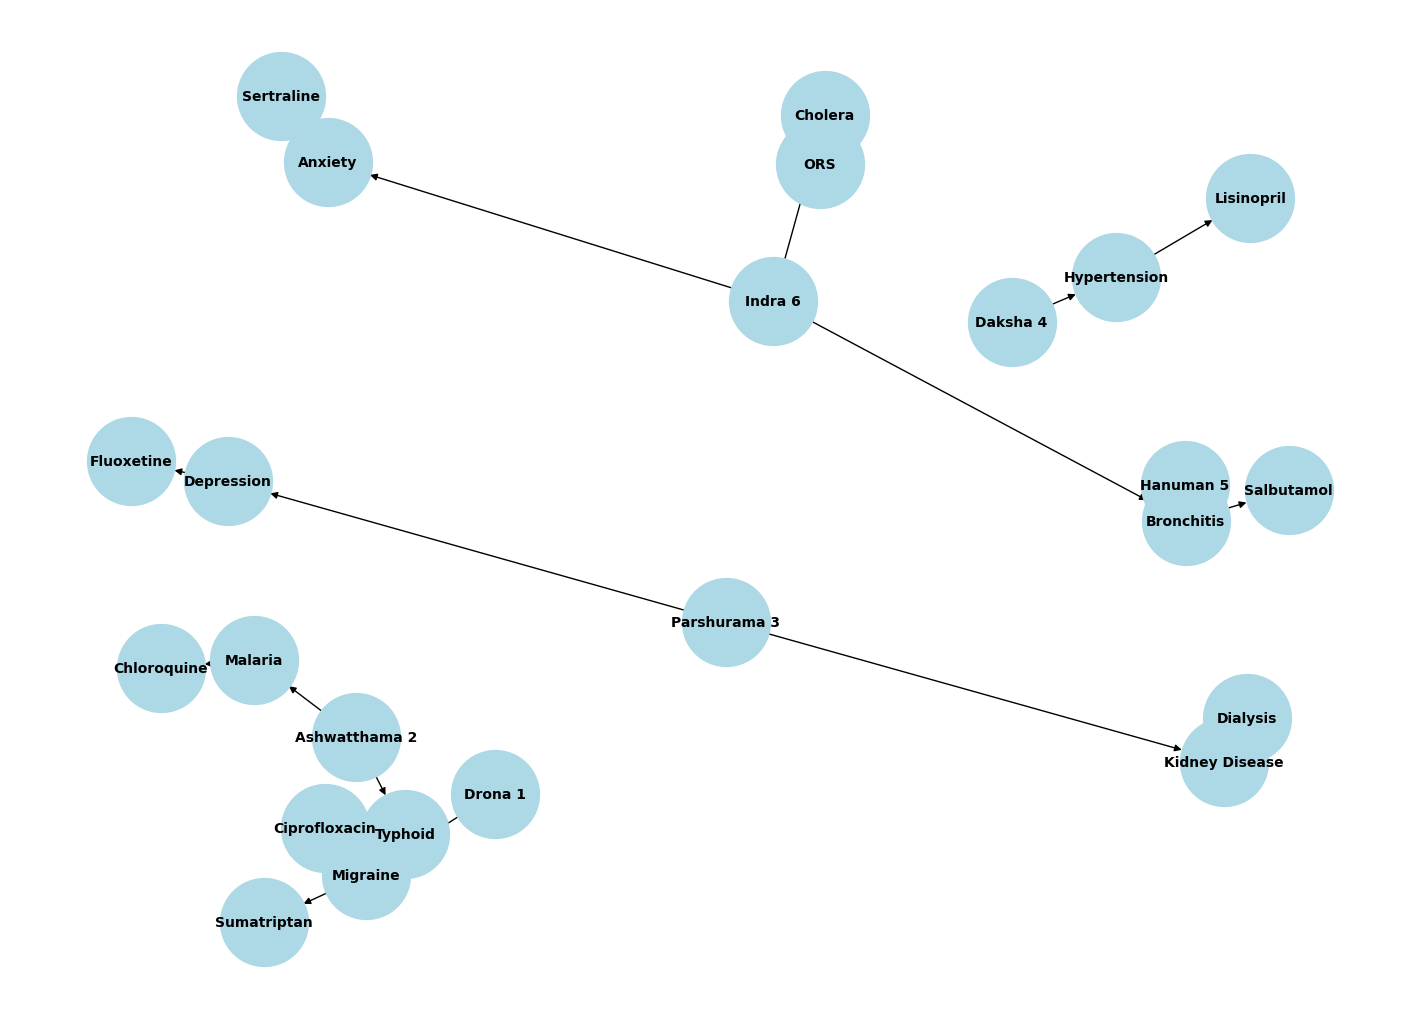


 Final Result:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add nodes for patients
patients = ["Drona 1", "Ashwatthama 2", "Parshurama 3", "Daksha 4", "Hanuman 5", "Indra 6"]
for patient in patients:
    G.add_node(patient)

# Add nodes for diseases and medications and connect them to the respective patients
G.add_edge("Drona 1", "Migraine")
G.add_edge("Migraine", "Sumatriptan")

G.add_edge("Ashwatthama 2", "Typhoid")
G.add_edge("Typhoid", "Ciprofloxacin")
G.add_edge("Ashwatthama 2", "Malaria")
G.add_edge("Malaria", "Chloroquine")

G.add_edge("Parshurama 3", "Depression")
G.add_edge("Depression", "Fluoxetine")
G.add_edge("Parshurama 3", "Kidney Disease")
G.add_edge("Kidney Disease", "Dialysis")

G.add_edge("Daksha 4", "Hypertension")
G.add_edge("Hypertension", "Lisinopril")

G.add_edge("Hanuman 5", "Bronchitis")
G.add_edge("Bronchitis", "Salbutamol")

G.add_edge("Indra 6", "Anxiety")
G.add_edge("Anxiety", "Sertraline")
G.add_edge

In [ ]:
user_query = "Visualize the patient with diseases"
print("\n Executing query...")
result = query_graph(user_query)
print("\n Final Result:")
print(result)
